# Categorical Feature Encoding Challenge II

**Задача** - бинарной классификации. Соревнование ставит своей целью научить работать с категориальными признаками. Датасет содержит:
- Бинарные признаки
- Номинальные признаки с низкими и высокими мощностями
- Порядковые признаки с низкими и высокими мощностями
- (Потенциально) цикличные признаки

**Метрика** - сабмиты оцениваются по площади под кривой ROC между предсказанной вероятностью и реальной меткой. Для каждого id необходимо предсказать вероятность таргета.

## 1. EDA (Разведочный анализ данных, Exploratory data analysis)

In [1]:
import seaborn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

Считываем тренировочные данные:

In [2]:
train_data = pd.read_csv("data/train.csv", index_col="id")
test_data = pd.read_csv("data/test.csv", index_col="id")
print(f"Shape of train data: {train_data.shape}. Shape of test data: {test_data.shape}")

Shape of train data: (600000, 24). Shape of test data: (400000, 23)


In [3]:
train_data.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,Bassoon,...,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,Theremin,...,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,Bassoon,...,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,Theremin,...,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,NaN,...,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


### Описание признаков

In [4]:
train_data.columns

Index(['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2',
       'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0',
       'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month', 'target'],
      dtype='object')

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600000 entries, 0 to 599999
Data columns (total 24 columns):
bin_0     582106 non-null float64
bin_1     581997 non-null float64
bin_2     582070 non-null float64
bin_3     581986 non-null object
bin_4     581953 non-null object
nom_0     581748 non-null object
nom_1     581844 non-null object
nom_2     581965 non-null object
nom_3     581879 non-null object
nom_4     581965 non-null object
nom_5     582222 non-null object
nom_6     581869 non-null object
nom_7     581997 non-null object
nom_8     582245 non-null object
nom_9     581927 non-null object
ord_0     581712 non-null float64
ord_1     581959 non-null object
ord_2     581925 non-null object
ord_3     582084 non-null object
ord_4     582070 non-null object
ord_5     582287 non-null object
day       582048 non-null float64
month     582012 non-null float64
target    600000 non-null int64
dtypes: float64(6), int64(1), object(17)
memory usage: 114.4+ MB


#### Краткое описание признаков:
* **bin 0~4** : Binary Feature, label encoding
* **nom 0~9** : Nominal Feature
* **ord 0~5** : Ordinal Feature
* **day/month** : Date, cycle encoding

Создадим списки признаков, соответствующие их группам

In [6]:
# Бинарные
bin_features = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4']
# Категориальные
nom_features = ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4']
# Хеш
hex_features = ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']
# Порядковые
ord_features = ['ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5']
ord_features_low_cardinality = ['ord_0', 'ord_1', 'ord_2']
ord_features_high_cardinality = ['ord_3', 'ord_4', 'ord_5']
# Цикличные
cyc_features = ['day', 'month']

### Анализируем целевую переменную

In [7]:
train_data['target'].describe()

count    600000.000000
mean          0.187205
std           0.390076
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: target, dtype: float64

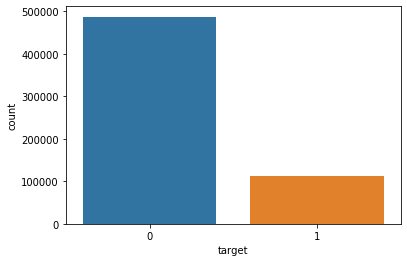

In [8]:
seaborn.countplot(x='target', data=train_data)

In [9]:
print ('Доля объектов с меткой 1 = {0:.3f}'.format(train_data.target.sum()/train_data.shape[0]))

Доля объектов с меткой 1 = 0.187


**Корелляция с признаками**

In [10]:
def print_percentage(df,col_name,col_values):
    for x in col_values:
        group = df.loc[df[col_name]==x]
        print ('{0} survival rate: {1:.3f}'.format(x, (group['target'].sum()/group.shape[0])))

In [11]:
def rand_jitter(arr,factor,limit):
    r = arr.max()-arr.min()
    stdev = factor*r
    arr = arr + np.random.randn(arr.shape[0]) * stdev
    arr = arr.clip(arr.min()-limit,arr.max()+limit)
    return arr

**Бинарные**

**Номинальные**

**Порядковые**

### Анализ признаков

**Пропуски в данных**

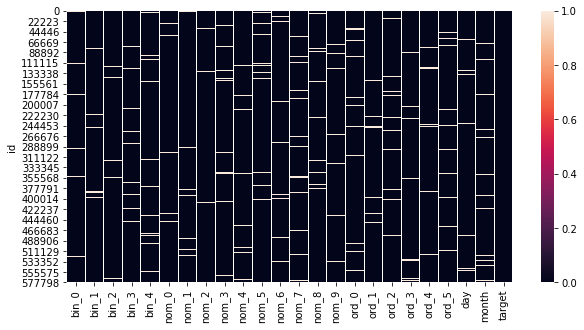

In [12]:
plt.figure(figsize=(10,5))
seaborn.heatmap(train_data.isnull());

**Добавить таблицу с количеством пропусков по фичам!!!**

**Обзор признаков**

**Проверяем наличие выбросов**

**Строим матрицу корреляции признаков между собой**

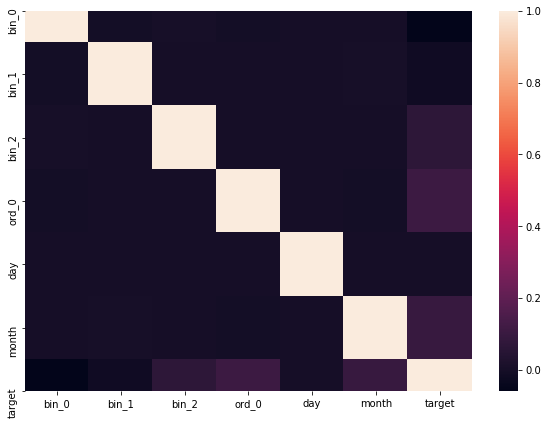

In [13]:
plt.figure(figsize=(10,7))
corrmat = train_data.corr()
seaborn.heatmap(corrmat,
               xticklabels=corrmat.columns.values, 
                yticklabels=corrmat.columns.values)

### Числовые признаки

Посмотрим на распределения числовых признаков

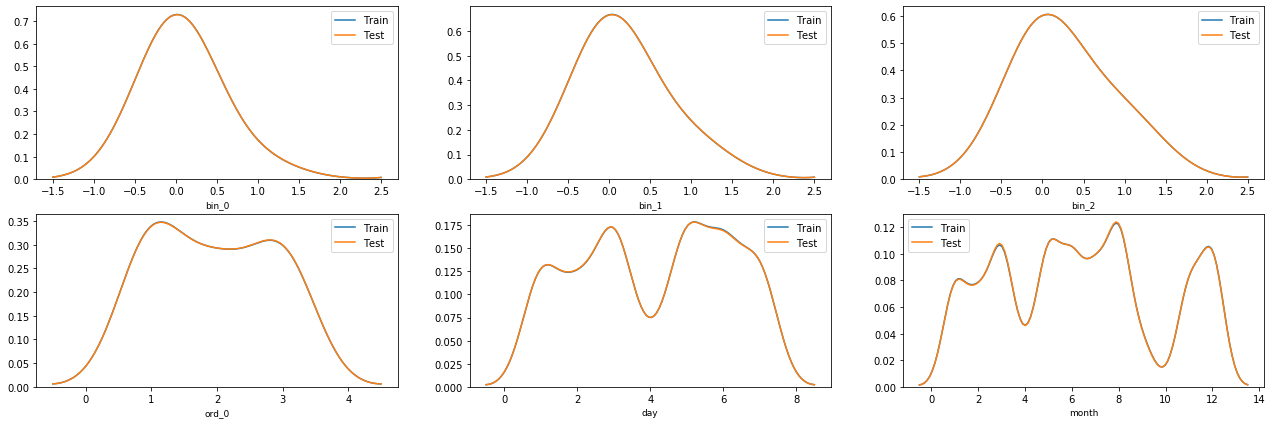

In [15]:
num_cols = test_data.select_dtypes(exclude=['object']).columns
fig, ax = plt.subplots(2,3,figsize=(22,7))
for i, col in enumerate(num_cols):
    plt.subplot(2,3,i+1)
    plt.xlabel(col, fontsize=9)
    seaborn.kdeplot(train_data[col].values, bw=0.5,label='Train')
    seaborn.kdeplot(test_data[col].values, bw=0.5,label='Test')
   
plt.show() 

Распрделения для обучающей и тестовой борок совпадают - это означает что не должно быть трудностей с обобщением результатов.

Построим графики распределений раздельно для объектов с метками 0 и 1

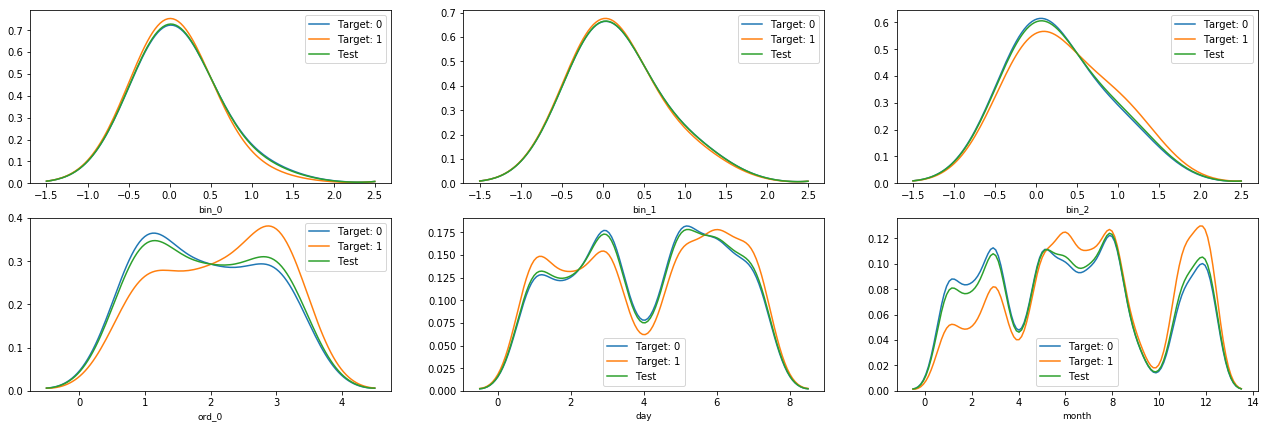

In [17]:
target0 = train_data.loc[train_data['target'] == 0]
target1 = train_data.loc[train_data['target'] == 1]

fig, ax = plt.subplots(2,3,figsize=(22,7))
for i, col in enumerate(num_cols):
    plt.subplot(2,3,i+1)
    plt.xlabel(col, fontsize=9)
    seaborn.kdeplot(target0[col].values, bw=0.5,label='Target: 0')
    seaborn.kdeplot(target1[col].values, bw=0.5,label='Target: 1')
    seaborn.kdeplot(test_data[col].values, bw=0.5,label='Test')
    
plt.show() 

### Бинарные признаки

In [18]:
# https://www.kaggle.com/warkingleo2000/first-step-on-kaggle
# https://www.kaggle.com/subinium/categorical-data-eda-visualization

In [19]:
train_data[bin_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600000 entries, 0 to 599999
Data columns (total 5 columns):
bin_0    582106 non-null float64
bin_1    581997 non-null float64
bin_2    582070 non-null float64
bin_3    581986 non-null object
bin_4    581953 non-null object
dtypes: float64(3), object(2)
memory usage: 47.5+ MB


### Номинальные признаки

In [20]:
# https://www.kaggle.com/warkingleo2000/first-step-on-kaggle
# https://www.kaggle.com/subinium/categorical-data-eda-visualization

In [21]:
train_data[nom_features + hex_features].head()

,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9
id,,,,,,,,,,
0,Red,Trapezoid,Hamster,Russia,Bassoon,de4c57ee2,a64bc7ddf,598080a91,0256c7a4b,02e7c8990
1,Red,Star,Axolotl,NaN,Theremin,2bb3c3e5c,3a3a936e8,1dddb8473,52ead350c,f37df64af
2,Red,NaN,Hamster,Canada,Bassoon,b574c9841,708248125,5ddc9a726,745b909d1,NaN
3,Red,Circle,Hamster,Finland,Theremin,673bdf1f6,23edb8da3,3a33ef960,bdaa56dd1,f9d456e57
4,Red,Triangle,Hamster,Costa Rica,NaN,777d1ac2c,3a7975e46,bc9cc2a94,NaN,c5361037c


In [22]:
train_data[nom_features + hex_features].nunique()

nom_0       3
nom_1       6
nom_2       6
nom_3       6
nom_4       4
nom_5    1220
nom_6    1519
nom_7     222
nom_8     222
nom_9    2218
dtype: int64

### Порядковые признаки

In [23]:
# https://www.kaggle.com/warkingleo2000/first-step-on-kaggle
# https://www.kaggle.com/subinium/categorical-data-eda-visualization
print(ord_features)

['ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5']


In [24]:
ord_features_low_cardinality = ['ord_0', 'ord_1', 'ord_2']
ord_features_high_cardinality = ['ord_3', 'ord_4', 'ord_5']

In [28]:
train_data[ord_features].head()

,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5
id,,,,,,
0,3.0,Contributor,Hot,c,U,Pw
1,3.0,Grandmaster,Warm,e,X,pE
2,3.0,NaN,Freezing,n,P,eN
3,1.0,Novice,Lava Hot,a,C,NaN
4,3.0,Grandmaster,Cold,h,C,OZ


In [25]:
train_data[ord_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600000 entries, 0 to 599999
Data columns (total 6 columns):
ord_0    581712 non-null float64
ord_1    581959 non-null object
ord_2    581925 non-null object
ord_3    582084 non-null object
ord_4    582070 non-null object
ord_5    582287 non-null object
dtypes: float64(1), object(5)
memory usage: 52.0+ MB


In [30]:
train_data[ord_features].nunique()

ord_0      3
ord_1      5
ord_2      6
ord_3     15
ord_4     26
ord_5    190
dtype: int64

### Цикличные признаки

In [ ]:
# https://www.kaggle.com/warkingleo2000/first-step-on-kaggle
# https://www.kaggle.com/subinium/categorical-data-eda-visualization

In [29]:
train_data[cyc_features].head()

,day,month
id,,
0,6.0,3.0
1,7.0,7.0
2,5.0,9.0
3,3.0,3.0
4,5.0,12.0


In [32]:
train_data[cyc_features].nunique()

day       7
month    12
dtype: int64